In [1]:
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('image', cmap='gray')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import os
from EyeTracking import EyeTrackingDataset

In [2]:
parser = argparse.ArgumentParser(description='EE148 Project')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--validation-percentage', type=float, default=15., metavar='P',
                   help='percentage of training data used for validation')
# parser.add_argument('--training-division', type=float, default=1., metavar='D',
#                    help='divide the remaining training data by this factor')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                    help='learning rate (default: 1.0)')
parser.add_argument('--step', type=int, default=1, metavar='N',
                    help='number of epochs between learning rate reductions (default: 1)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--reg-lambda', type=float, default=0.001, metavar='L',
                    help='Regularization lambda (default:0.001)')
parser.add_argument('--no-cuda', action='store_true',
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=200, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--evaluate', action='store_true',
                    help='evaluate your model on the official test set')
parser.add_argument('--load-model', type=str,
                    help='model file path')
parser.add_argument('--save-model', type=str,
                    help='For Saving the current Model');

args = parser.parse_args('--validation-percentage 10 --batch-size 64 --epochs 8 --lr 1 --step 1 --gamma 0.9 --reg-lambda 0.0008 --seed 2020 --log-interval 20'.split())

use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
path_outputs = '.'

In [3]:
dir_images = r'E:\Data\Unity\Minos\images'
path_pos = r'E:\Data\Unity\Minos\pos.bin'
dataset = EyeTrackingDataset(path_pos, dir_images, polar=False, transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(120),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.ToTensor()
]))

rng = np.random.default_rng(args.seed)
idc = rng.permutation(len(dataset))
n_train = np.round(len(dataset)*(1-args.validation_percentage/100)).astype(int)

train_loader = DataLoader(
    dataset, batch_size=args.batch_size,
    sampler=SubsetRandomSampler(idc[:n_train]), **kwargs
)
val_loader = DataLoader(
    dataset, batch_size=args.batch_size,
    sampler=SubsetRandomSampler(idc[n_train:]), **kwargs
)

print(f'Loaded {len(dataset)} samples and divided into {len(train_loader.sampler)} training and {len(val_loader.sampler)} validation samples')

Loaded 32000 samples and divided into 28800 training and 3200 validation samples


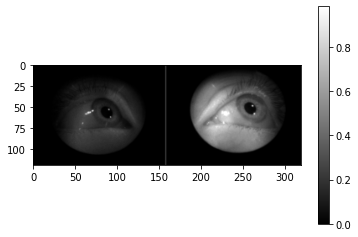

[-0.17859761  0.12360682  0.33589324  1.        ]
[-0.32602817  0.20405532  0.7944753   1.        ]


In [4]:
plt.imshow(dataset[0][0].numpy().squeeze())
plt.colorbar()
plt.show()
print(dataset[0][1])
print(dataset[0][2])

In [5]:
def train_pos(args, model, device, train_loader, optimizer, epoch, weight=torch.ones(1, 4), reg_lambda=0.001, verbose=True):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train()   # Set the model to training mode
    for batch_idx, (data, target, ref) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        weight_pos = torch.sqrt(weight[0, 0:3])
        loss = F.mse_loss(output[:, 0:3]*weight_pos, target[:, 0:3]*weight_pos)   # Compute loss
        for param in model.parameters():    # Compute regularization
            loss += reg_lambda*torch.mean(torch.abs(param))
        loss.backward()                     # Gradient computation
        optimizer.step()                    # Perform a single optimization step
        if batch_idx % args.log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.sampler),
                100. * batch_idx * len(data) / len(train_loader.sampler), loss.item()))

def test(model, device, test_loader, weight=torch.ones(1, 4), name='Validation', verbose=True):
    model.eval()    # Set the model to inference mode
    test_loss = 0.
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target, ref in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            weight_pos = torch.sqrt(weight[0, 0:3])
            test_loss += F.mse_loss(output[:, 0:3]*weight_pos, target[:, 0:3]*weight_pos, reduction='sum').item()  # sum up batch loss

    test_loss /= len(test_loader.sampler)
    
    if verbose:
        print('{:s} set: Average loss: {:.4f}'.format(
            name, test_loss))
    
    return test_loss


In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.ELU()
        # (1, 120, 320)
        
        self.d1 = 16
        self.conv1 = nn.Conv2d(1, self.d1, kernel_size=3, stride=1, padding=1, padding_mode='replicate')
        # (16, 120, 320)
        self.batchNorm1 = nn.BatchNorm2d(self.d1)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout2d1 = nn.Dropout2d(0.8)
        # (16, 60, 160)
        
        self.d2 = 32
        self.conv2 = nn.Conv2d(self.d1, self.d2, kernel_size=3, stride=1, padding=1, padding_mode='replicate')
        # (32, 60, 160)
        self.batchNorm2 = nn.BatchNorm2d(self.d2)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2d2 = nn.Dropout2d(0.8)
        # (32, 30, 80)
        
        self.d3 = 32
        self.conv3 = nn.Conv2d(self.d2, self.d3, kernel_size=3, stride=1, padding=1, padding_mode='replicate')
        # (32, 30, 80)
        self.batchNorm3 = nn.BatchNorm2d(self.d3)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout2d3 = nn.Dropout2d(0.8)
        # (32, 15, 40)
        
        self.d4 = 64
        self.conv4 = nn.Conv2d(self.d3, self.d4, kernel_size=3, stride=1, padding=1, padding_mode='replicate')
        # (64, 15, 40)
        self.batchNorm4 = nn.BatchNorm2d(self.d4)
        self.pool4 = nn.MaxPool2d(2)
        self.dropout2d4 = nn.Dropout2d(0.8)
        # (64, 7, 20)
        
        self.d5 = 64
        self.conv5 = nn.Conv2d(self.d4, self.d5, kernel_size=3, stride=1, padding=1, padding_mode='replicate')
        # (64, 7, 20)
        self.batchNorm5 = nn.BatchNorm2d(self.d5)
        self.pool5 = nn.MaxPool2d(2)
        self.dropout2d5 = nn.Dropout2d(0.8)
        # (64, 3, 10)
        
        self.fc1 = nn.Linear(1920, 16)
        self.dropout1 = nn.Dropout(0.8)
        self.fc2 = nn.Linear(16, 16)
        self.dropout2 = nn.Dropout(0.8)
        self.fc3 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = self.act(x)
        x = self.pool1(x)
        x = self.dropout2d1(x)

        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = self.act(x)
        x = self.pool2(x)
        x = self.dropout2d2(x)

        x = self.conv3(x)
        x = self.batchNorm3(x)
        x = self.act(x)
        x = self.pool3(x)
        x = self.dropout2d3(x)

        x = self.conv4(x)
        x = self.batchNorm4(x)
        x = self.act(x)
        x = self.pool4(x)
        x = self.dropout2d4(x)

        x = self.conv5(x)
        x = self.batchNorm5(x)
        x = self.act(x)
        x = self.pool5(x)
        x = self.dropout2d5(x)

        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.act(x)
        #x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.act(x)
        #x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

In [7]:
test_model = Net()
test_model.forward(torch.ones(2, 1, 120, 320))

tensor([[-0.1778, -0.0857, -0.0681],
        [-0.2844, -0.0117, -0.4620]], grad_fn=<AddmmBackward>)

In [8]:
print([param.numel() for param in test_model.parameters()])

[144, 16, 16, 16, 4608, 32, 32, 32, 9216, 32, 32, 32, 18432, 64, 64, 64, 36864, 64, 64, 64, 30720, 16, 256, 16, 48, 3]


In [11]:
torch.cuda.empty_cache()

# Load your model [fcNet, ConvNet, Net]
model = Net().to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=1)

# Training loop
weight = torch.tensor([1., 1., 1., 0.], device=device).reshape((1, 4))
args.epochs = 16
train_loss = np.zeros((args.epochs,))
val_loss = np.zeros((args.epochs,))
for epoch in range(args.epochs):
    train_pos(args, model, device, train_loader, optimizer, epoch, weight=weight, reg_lambda=args.reg_lambda, verbose=True)
    #train_loss[epoch] = test(model, device, train_loader, name='Training')
    val_loss[epoch] = test(model, device, val_loader, weight=weight, name='Validation')
    print()
    scheduler.step()    # learning rate scheduler

Train Epoch: 1 [0/28800 (0%)]	Loss: 10.978692
Train Epoch: 1 [1280/28800 (4%)]	Loss: 5.238456
Train Epoch: 1 [2560/28800 (9%)]	Loss: 4.221282
Train Epoch: 1 [3840/28800 (13%)]	Loss: 4.058925
Train Epoch: 1 [5120/28800 (18%)]	Loss: 3.986026


KeyboardInterrupt: 